In [6]:
!git clone https://github.com/Miamoto/fruit-classifier

fatal: destination path 'fruit-classifier' already exists and is not an empty directory.


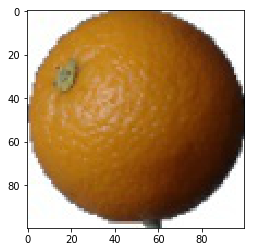

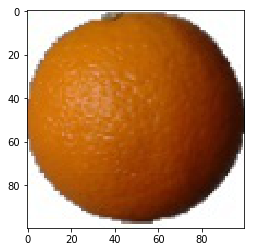

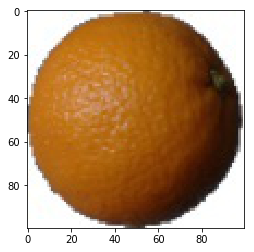

y_train [3 2 2 ... 1 1 2]
Shape of train images is: (1333, 224, 224, 3)
Shape of validation image (572, 224, 224, 3)
Shape of labels is: (1333,)
Shape of label (572,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 0s 0us/step


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 23 11:07:57 2019

@author: anama
"""

import numpy as np
import keras
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense,Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from IPython.display import display 
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical

train_data_dir = "fruit-classifier/dataset/Training"
test_data_dir = "fruit-classifier/dataset/Test"
weights_filename = "weights.hdf5"


nb_batch_size = 16

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

list_apples = ['Apple Crimson Snow','Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1'
, 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2' ]


list_lemons = ['Lemon', 'Lemon Meyer']
list_pears = ['Pear Abate', 'Pear Kaiser', 'Pear Monster', 'Pear Red','Pear Williams']
def process_images(lst, root_dir):
    res = []
    for obj in lst:
        data_dir = root_dir + '/'+ obj 
        res.append([data_dir + '/{}'.format(i) for i in os.listdir(data_dir)])
    return res

train_apple = process_images(list_apples,train_data_dir)
train_orange = process_images(['Orange'], train_data_dir)
train_lemon = process_images(list_lemons, train_data_dir)
train_pear = process_images(list_pears, train_data_dir)

test_apple = process_images(list_apples,test_data_dir)
test_orange = process_images(['Orange'], test_data_dir)
test_lemon = process_images(list_lemons, test_data_dir)
test_pear = process_images(list_pears, test_data_dir)

test_set = test_orange[:] + test_apple[:] + test_lemon[:] + test_pear[:]
train_set = train_orange[:] + train_apple[:] + train_lemon[:] + train_pear[:]
random.shuffle(train_set)

train_apple = train_apple[0]
train_orange = train_orange[0]
train_lemon = train_lemon[0]
train_pear = train_pear[0]


test_apple = test_apple[0]
test_orange = test_orange[0]
test_lemon = test_lemon[0]
test_pear = test_pear[0]


import matplotlib.image as mpimg
for ima in train_orange[0:3]:
    img = mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()
    

train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) 

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)
nrws = 224
ncolumns = 224
channels = 3


X = [] #images
y = [] #labels

for image in train_apple:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(0)
    
for image in train_orange:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(1)

for image in train_lemon:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(2)
    
for image in train_pear:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(3)



X = np.array(X)
y = np.array(y)


from sklearn.model_selection import train_test_split
#30% validation set, 70% training set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)

print("y_train", y_train)
print("Shape of train images is:", X_train.shape)
print("Shape of validation image", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of label", y_val.shape)

num_classes = 4
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

train_generator = train_datagen.flow(X_train, y_train,batch_size=nb_batch_size)
validation_generator = train_datagen.flow(X_val, y_val, batch_size=nb_batch_size)


mobile = keras.applications.mobilenet.MobileNet()
# mobile.summary()


x = mobile.layers[-6].output #not include last five layers
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

# model.summary()
    
#how many layers to retrain?
# set the last 10 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
#train last 10 layers.
for layer in model.layers[:-10]:
    layer.trainable = False
    


    
    


In [0]:
def process_image(file):
    img_path = "MobileNet-inference-images/"
    img = image.load_image(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_expanded)
    
    

In [0]:
import math
model.compile(Adam(lr=0.01), loss='categorical_crossentropy',metrics=['accuracy'])
nb_steps_per_epoch = math.floor(X_train.shape[0]/nb_batch_size)
nb_validation_steps = math.floor(X_val.shape[0]/nb_batch_size)
print(nb_steps_per_epoch)
checkpoint = ModelCheckpoint(weights_filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(train_generator, steps_per_epoch=4, validation_data = validation_generator, 
                               validation_steps=2,epochs=20, verbose=2)


27
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 41s - loss: 0.6465 - acc: 0.7500 - val_loss: 12.5923 - val_acc: 0.2188
Epoch 2/20
 - 35s - loss: 0.0520 - acc: 0.9844 - val_loss: 13.5996 - val_acc: 0.1562
Epoch 3/20
 - 33s - loss: 1.9390e-04 - acc: 1.0000 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 4/20
 - 33s - loss: 0.6457 - acc: 0.8750 - val_loss: 12.0025 - val_acc: 0.2500
Epoch 5/20
 - 30s - loss: 2.2046e-06 - acc: 1.0000 - val_loss: 7.0674 - val_acc: 0.5625
Epoch 6/20
 - 32s - loss: 0.4365 - acc: 0.9219 - val_loss: 7.0463 - val_acc: 0.5312
Epoch 7/20
 - 31s - loss: 4.8244e-07 - acc: 1.0000 - val_loss: 7.2751 - val_acc: 0.5000
Epoch 8/20
 - 30s - loss: 1.3702e-04 - acc: 1.0000 - val_loss: 5.3399 - val_acc: 0.5938
Epoch 9/20
 - 29s - loss: 0.0293 - acc: 0.9844 - val_loss: 4.6962 - val_acc: 0.4062
Epoch 10/20
 - 29s - loss: 2.2561e-04 - acc: 1.0000 - val_loss: 2.8891 - val_acc: 0.6562
Epoch 11/20
 - 29s - loss: 3.1602e-05 - acc: 1.0000 - val_loss: 4.4835 - val_acc: 0.

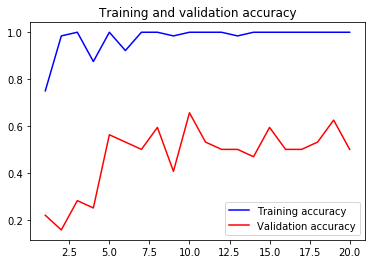

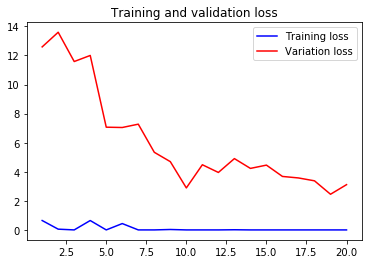

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Variation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:

X_test = [] #images
y_test = [] #labels

for image in test_apple:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y_test.append(0)
    
for image in test_orange:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y_test.append(1)

for image in test_lemon:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y_test.append(2)
    
for image in test_pear:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y_test.append(3)

""""""
X_test = np.array(X_test)
y_test = np.array(y_test)
y_true = y_test
print("y_true", y_true)
print("y_test", y_test.shape)
y_test = to_categorical(y_test, num_classes)

print("y_test", y_test)
print("y_test", y_test.shape)
print("Shape of test images is:", X_test.shape)


test_generator = test_datagen.flow(X_test, y_test, batch_size=20)
print("fim")

y_true [0 0 0 ... 3 3 3]
y_test (1905,)
y_test [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
y_test (1905, 4)
Shape of test images is: (1905, 224, 224, 3)
fim


In [0]:
model.load_weights(weights_filename)
predictions = model.predict_generator(test_generator, steps=96, verbose=2)
print(predictions)

In [0]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
                       
y_pred = predictions.argmax(axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0,
       2, 0, 0, 2, 3, 0, 0, 3, 0, 2, 0, 0, 0, 2, 0, 0, 3, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       2, 0, 3, 0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 2, 2, 2, 3, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 2, 0, 0, 2, 0, 3, 0,
       3, 0, 0, 3, 2, 0, 0, 0, 2, 3, 0, 3, 2, 2, 0, 2, 2, 0, 0, 2, 3, 0,
       3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 2,

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true[:1905], y_pred)

0.241994750656168

In [0]:
#cm = confusion_matrix(test_labels, predictions.argmax(axis=1))